# Cell features

In this notebook we develop and evaluate the various cell feature both for classification which describe both the shape and intensity distribution in a given cell.

In [ ]:
from notebook_utils import *

import imageio
import skimage.segmentation
import skimage.filters

import scipy.stats

import random

import os
import shutil

%matplotlib inline

## Load input data

In [2]:
import clb.dataprep.utils
import scipy.stats
dir_root = r'D:\Fafa\MIT\CellDx\preprocessing'

O:\Code\cldx-pilot\cldx\dataprep\imageioplug\tifformat.py:115: SwappedAxesWarning: Reader sees t and z axis as swapped.
  SwappedAxesWarning)
O:\Code\cldx-pilot\cldx\dataprep\imageioplug\tifformat.py:187: ChannelWarning: Reader couldn't read just one channel, so it read all of them.
  " read all of them.", ChannelWarning)


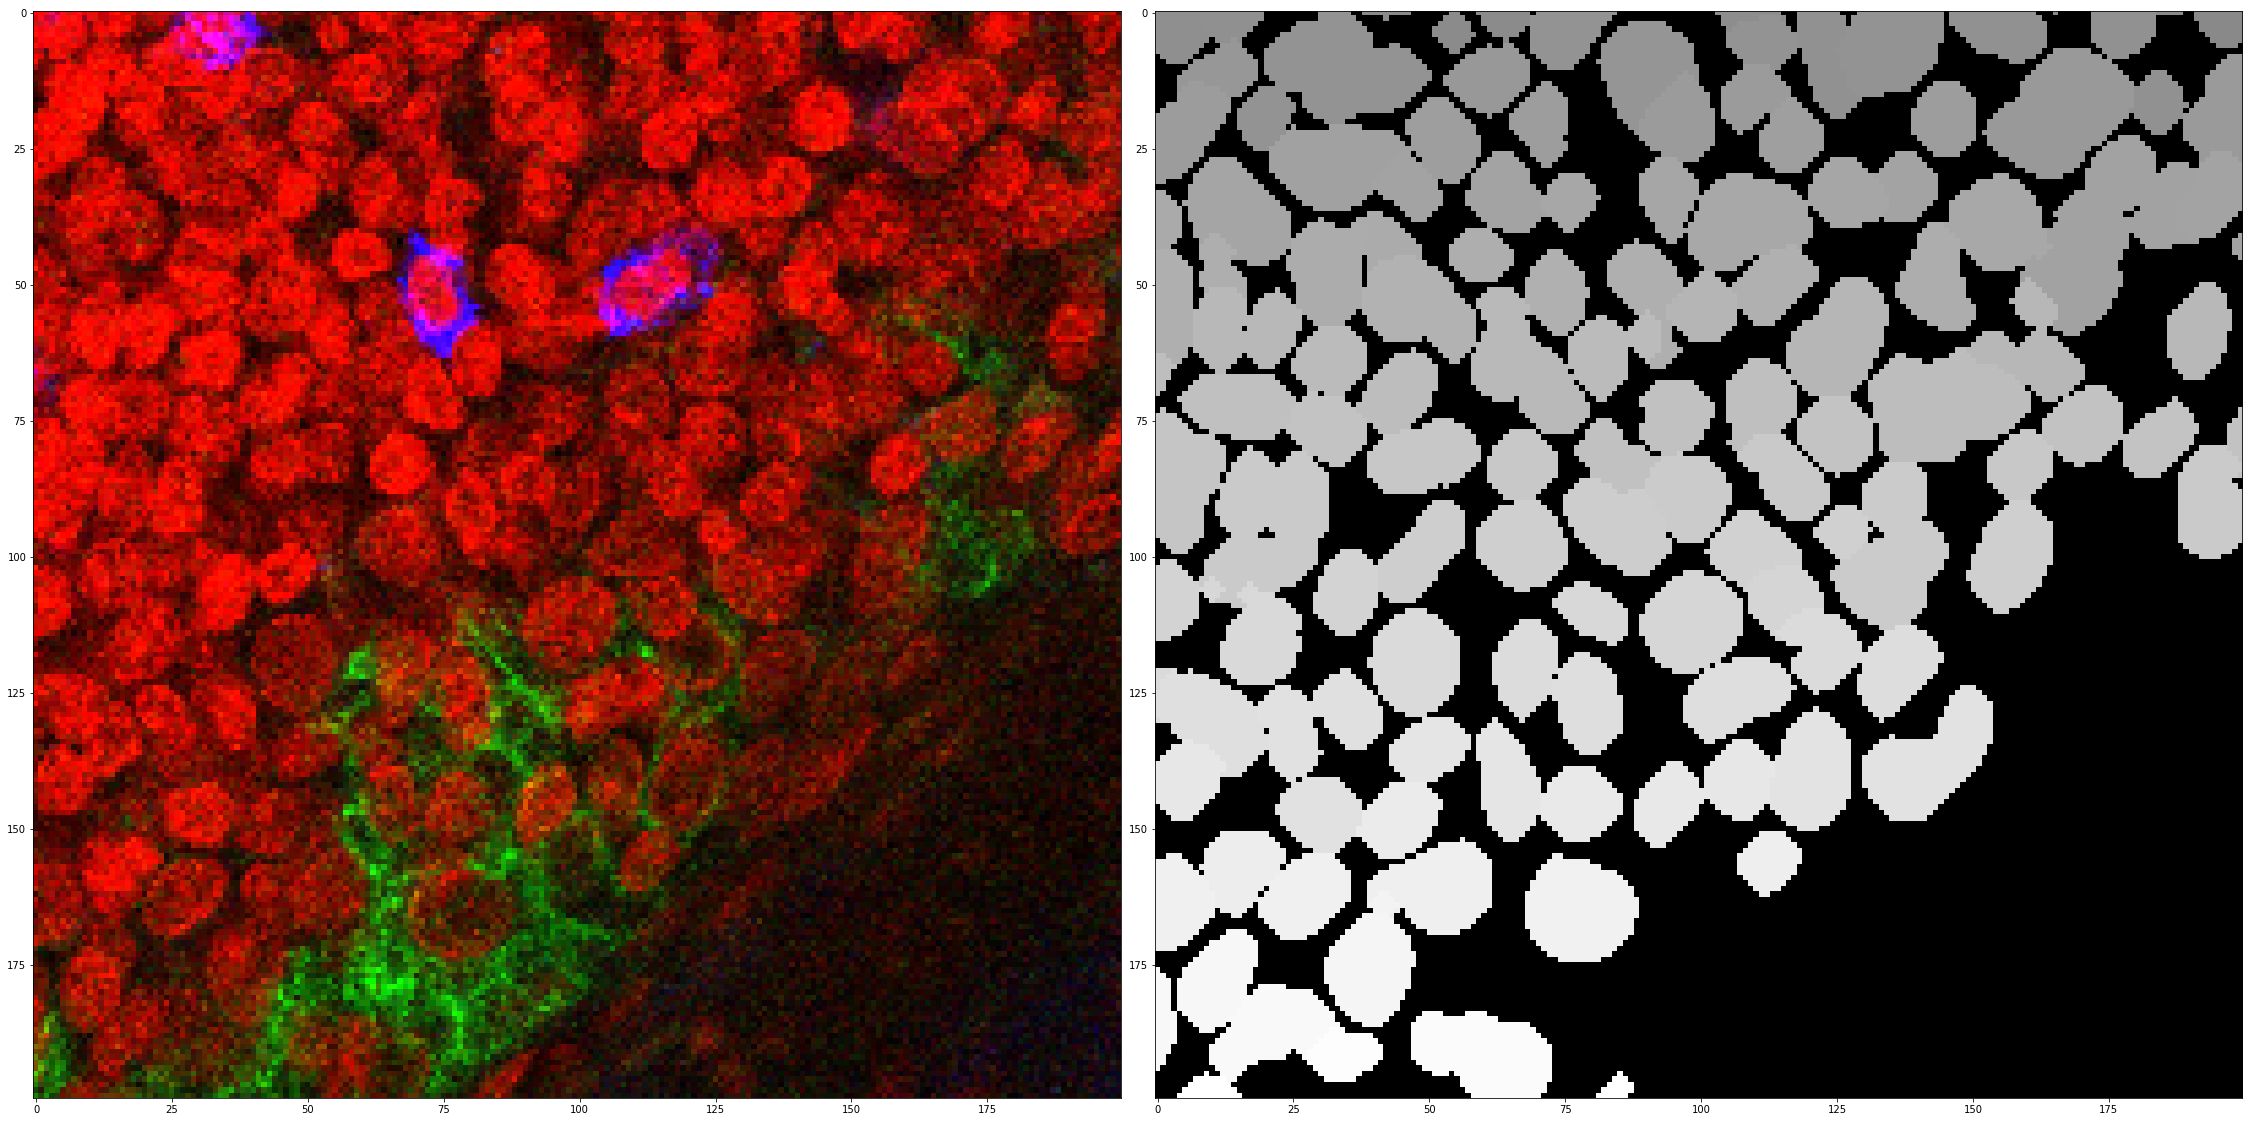

In [3]:
path_3d = os.path.join(dir_root, 'TestNewClasses S1 1024 crop_class_pdlcd_9.tif')
data_input = imageio.volread(path_3d)[::,150:350,150:350,::]
data_input_normalized = clb.dataprep.utils.rescale_to_float(data_input, float_type='float32')

path_3d_labels = os.path.join(dir_root, 'TestNewClasses S1 1024 crop_class_pdlcd_9_segmented.tif')
data_input_labels = imageio.volread(path_3d_labels)[::,150:350,150:350]
show_all(1,2,data_input[0], data_input_labels[0], scale=20)

(10, 200, 200)


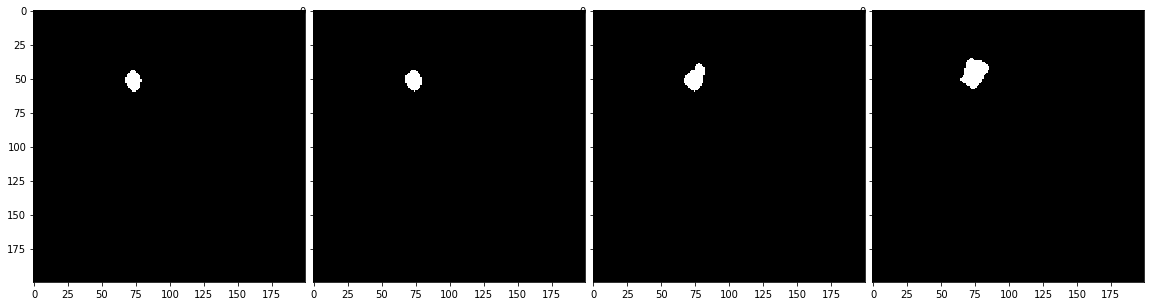

In [4]:
one_cell_label = 418
one_cell = data_input_labels[0:10] == one_cell_label
print(one_cell.shape)
show_all(1,4,one_cell[0], one_cell[1], one_cell[2], one_cell[-1], scale=5)

## Focus on CD8 cell

BBox: (0, 35, 65, 10, 60, 86) BBox_area: 5250 Area: 2254
prop.image: (10, 25, 21)


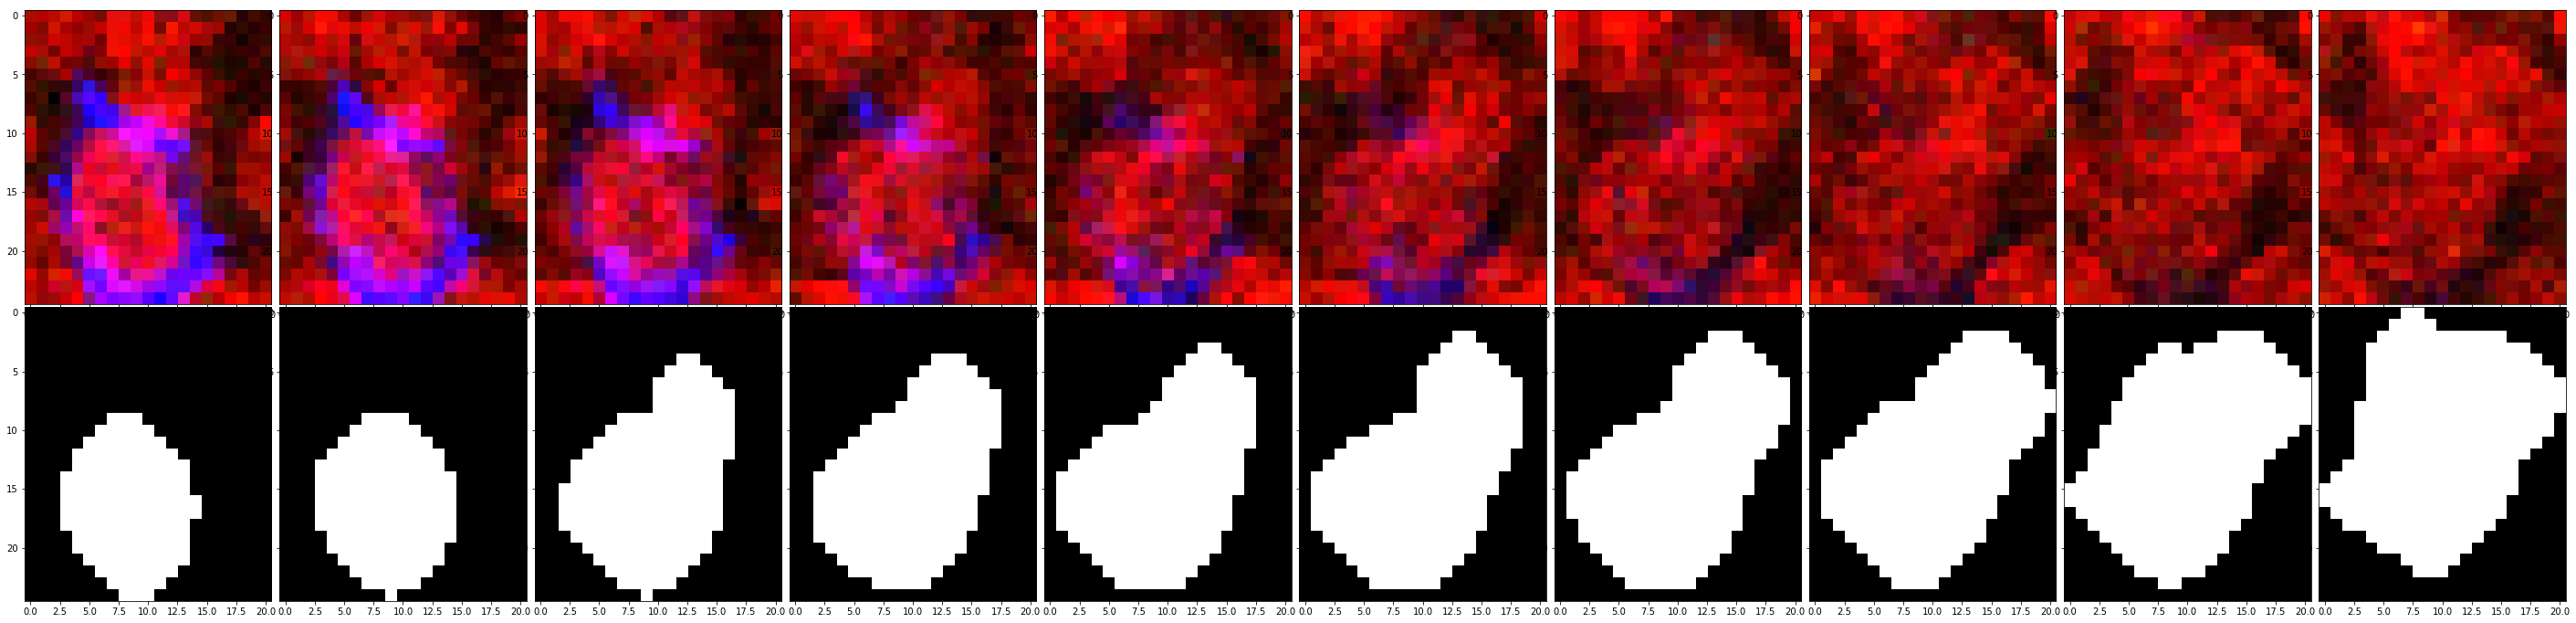

In [5]:
import skimage.measure as measure

prop = measure.regionprops(one_cell.astype(np.uint8), one_cell)[0]
cell_slice = prop._slice

cell_image = data_input_normalized[cell_slice]
cell_label = (data_input_labels[cell_slice] == one_cell_label).astype(np.uint8)

print("BBox:", prop.bbox, "BBox_area:", prop.bbox_area, "Area:", prop.area)
print("prop.image:", prop.image.shape)

show_all(2,len(cell_image), *(list(cell_image[:]) + list(cell_label[:])), scale=5)

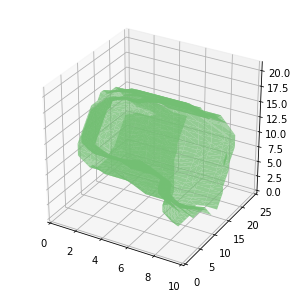

In [6]:
#%matplotlib notebook
plot_3d(cell_label)

## Rescaling

In [7]:
import clb.image_processing
importlib.reload(clb.image_processing)
from clb.image_processing import resample

#print(np.unique(cell_label))
#print(cell_label.shape)
#print(resample(cell_label, new_pixel_size=(2,2,1))[0].shape)
#print(resample(cell_label, new_pixel_size=(2,2,1))[0].dtype)
#print(resample(cell_label, new_pixel_size=(2,2,1))[1])
#print(resample(cell_label, new_pixel_size=(0.5,0.5,0.5))[0].shape)
#print(resample(cell_label, new_pixel_size=(0.5,0.5,0.5))[1])
#print(resample(cell_label, pixel_size=(0.57, 0.57, 1), new_pixel_size=(0.5,0.5,0.5))[0].shape)
#print(resample(cell_label, pixel_size=(0.57, 0.57, 1), new_pixel_size=(0.5,0.5,0.5))[1])
#print(np.unique(resample(cell_label, pixel_size=(0.57, 0.57, 1), new_pixel_size=(0.5,0.5,0.5))[0]))

In [8]:
import skimage.transform
def resample2(volume, pixel_size=(1,1,1), new_pixel_size=(1,1,1)):
    if pixel_size != new_pixel_size:
        pixel_size = np.array(pixel_size, dtype=np.float32)
        resize_factor = pixel_size / new_pixel_size
        
        new_real_shape = volume.shape[:3] * resize_factor
        new_shape = np.maximum(1, np.round(new_real_shape))
        real_resize_factor = new_shape / volume.shape[:3]
        
        final_pixel_size = pixel_size / real_resize_factor

        resampled_volume = skimage.transform.rescale(volume, real_resize_factor, 
                                           multichannel=volume.ndim == 4, order=1, mode='edge', 
                                           preserve_range=True, anti_aliasing=False)
        
        if volume.dtype in [np.bool, np.uint8, np.uint16]:
            resampled_volume = resampled_volume.astype(volume.dtype)
    return resampled_volume, final_pixel_size

### Normalize focus cell

Shape org:  (10, 25, 21, 3) (10, 25, 21) Type:  float32 uint8
Shape:  (20, 28, 24, 3) (20, 28, 24) Type:  float32 uint8
BBox: (0, 0, 0, 10, 25, 21) BBox_area: 5250 Area: 126
Image org:  DescribeResult(nobs=15750, minmax=(0.0, 1.0), mean=0.22676378, variance=0.08257126, skewness=1.1938587427139282, kurtosis=0.13598311013299913)
Labels org:  DescribeResult(nobs=5250, minmax=(0, 1), mean=0.42933333333333334, variance=0.24505289896488217, skewness=0.2855328268027719, kurtosis=-1.9184710048180178)
Image:  DescribeResult(nobs=40320, minmax=(0.0, 1.0), mean=0.22629331, variance=0.07644774, skewness=1.0986634492874146, kurtosis=-0.14581206140615288)
Labels:  DescribeResult(nobs=13440, minmax=(0, 1), mean=0.43578869047619045, variance=0.2458952035033077, skewness=0.2589897947024923, kurtosis=-1.9329242862399612)


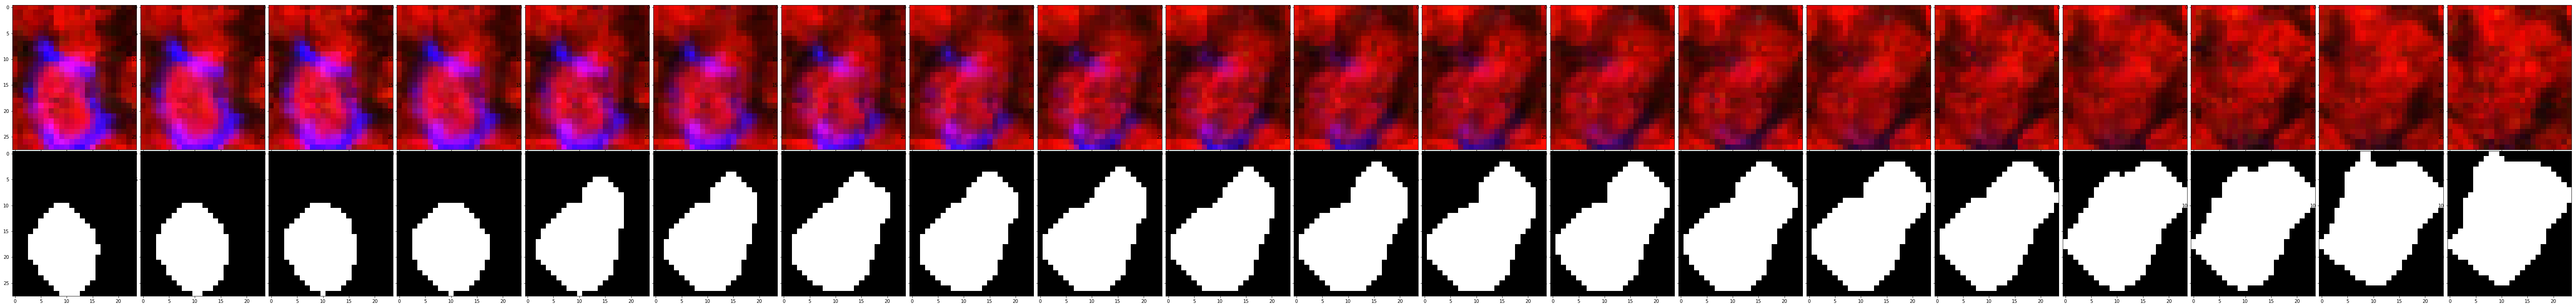

In [9]:
normalized_cell_image = resample(cell_image, pixel_size=(1, 0.57, 0.57), new_pixel_size=(0.5, 0.5,0.5))[0]
normalized_cell_label = resample(cell_label.astype(np.uint8), pixel_size=(1, 0.57, 0.57), new_pixel_size=(0.5, 0.5,0.5))[0]
normalized_prop = measure.regionprops(cell_image[...,0].astype(np.uint8), cell_label)[0]

print("Shape org: ",cell_image.shape, cell_label.shape, "Type: ", cell_image.dtype, cell_label.dtype )
print("Shape: ",normalized_cell_image.shape, normalized_cell_label.shape,  "Type: ", cell_image.dtype, normalized_cell_label.dtype)
print("BBox:", normalized_prop.bbox, "BBox_area:", normalized_prop.bbox_area, "Area:", normalized_prop.area)

print("Image org: ", scipy.stats.describe(cell_image, axis=None))
print("Labels org: ", scipy.stats.describe(cell_label, axis=None))
print("Image: ", scipy.stats.describe(normalized_cell_image, axis=None))
print("Labels: ", scipy.stats.describe(normalized_cell_label, axis=None))
#print("Labels vals: ", np.unique(normalized_cell_label))

show_all(2,len(normalized_cell_image), *(list(normalized_cell_image[:]) + list(normalized_cell_label[:])), scale=5)

Shape org:  (10, 25, 21, 3) (10, 25, 21) Type:  float32 uint8
Shape:  (20, 28, 24, 3) (20, 28, 24) Type:  float32 uint8
BBox: (11, 0, 5, 20, 1, 24) BBox_area: 171 Area: 7
Image org:  DescribeResult(nobs=15750, minmax=(0.0, 1.0), mean=0.22676378, variance=0.08257126, skewness=1.1938587427139282, kurtosis=0.13598311013299913)
Labels org:  DescribeResult(nobs=5250, minmax=(0, 1), mean=0.42933333333333334, variance=0.24505289896488217, skewness=0.2855328268027719, kurtosis=-1.9184710048180178)
Image:  DescribeResult(nobs=40320, minmax=(0.0, 1.0), mean=0.22693788649466357, variance=0.07699219661948435, skewness=1.0956303870139492, kurtosis=-0.1598377177441752)
Labels:  DescribeResult(nobs=13440, minmax=(0, 1), mean=0.33779761904761907, variance=0.22370703248186694, skewness=0.6859043537243734, kurtosis=-1.5295352175419494)


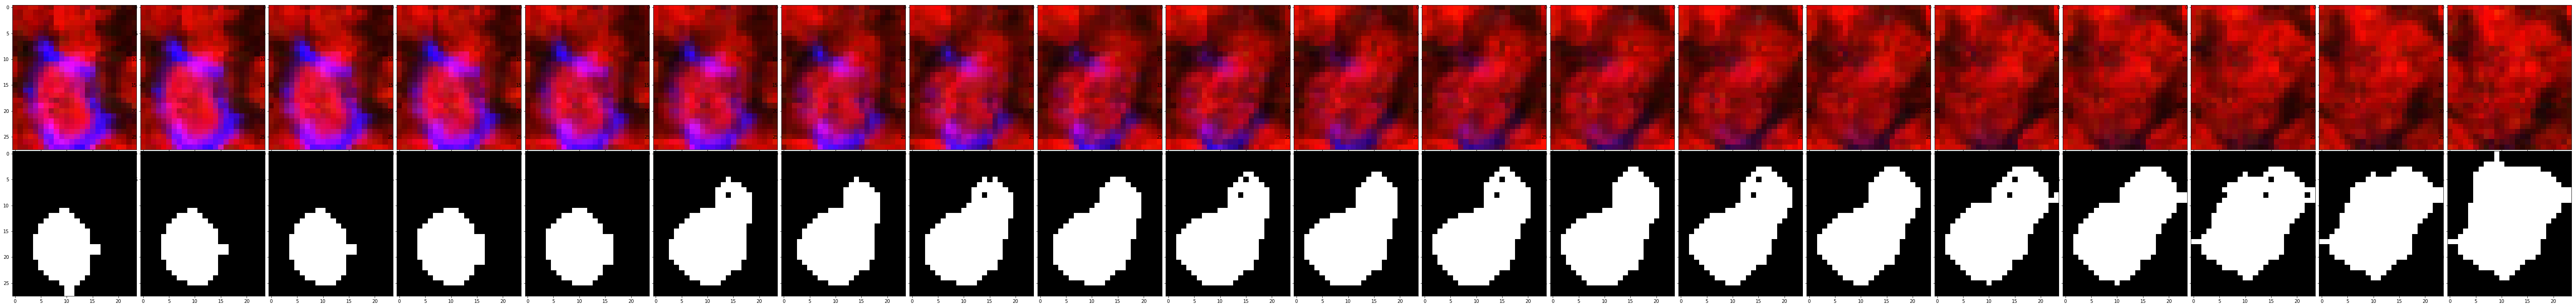

In [10]:
normalized_cell_image = resample2(cell_image, pixel_size=(1, 0.57, 0.57), new_pixel_size=(0.5, 0.5,0.5))[0]
normalized_cell_label = resample2(cell_label.astype(np.uint8), pixel_size=(1, 0.57, 0.57), new_pixel_size=(0.5, 0.5,0.5))[0]
normalized_prop = measure.regionprops(normalized_cell_image[...,0].astype(np.uint8), normalized_cell_label)[0]

print("Shape org: ",cell_image.shape, cell_label.shape, "Type: ", cell_image.dtype, cell_label.dtype )
print("Shape: ",normalized_cell_image.shape, normalized_cell_label.shape,  "Type: ", cell_image.dtype, normalized_cell_label.dtype)
print("BBox:", normalized_prop.bbox, "BBox_area:", normalized_prop.bbox_area, "Area:", normalized_prop.area)

print("Image org: ", scipy.stats.describe(cell_image, axis=None))
print("Labels org: ", scipy.stats.describe(cell_label, axis=None))
print("Image: ", scipy.stats.describe(normalized_cell_image, axis=None))
print("Labels: ", scipy.stats.describe(normalized_cell_label, axis=None))
#print("Labels vals: ", np.unique(normalized_cell_label))

show_all(2,len(normalized_cell_image), *(list(normalized_cell_image[:]) + list(normalized_cell_label[:])), scale=5)

Shape org:  (10, 25, 21, 3) (10, 25, 21) Type:  float32
Shape:  (20, 28, 24, 3) (20, 28, 24) Type:  float32


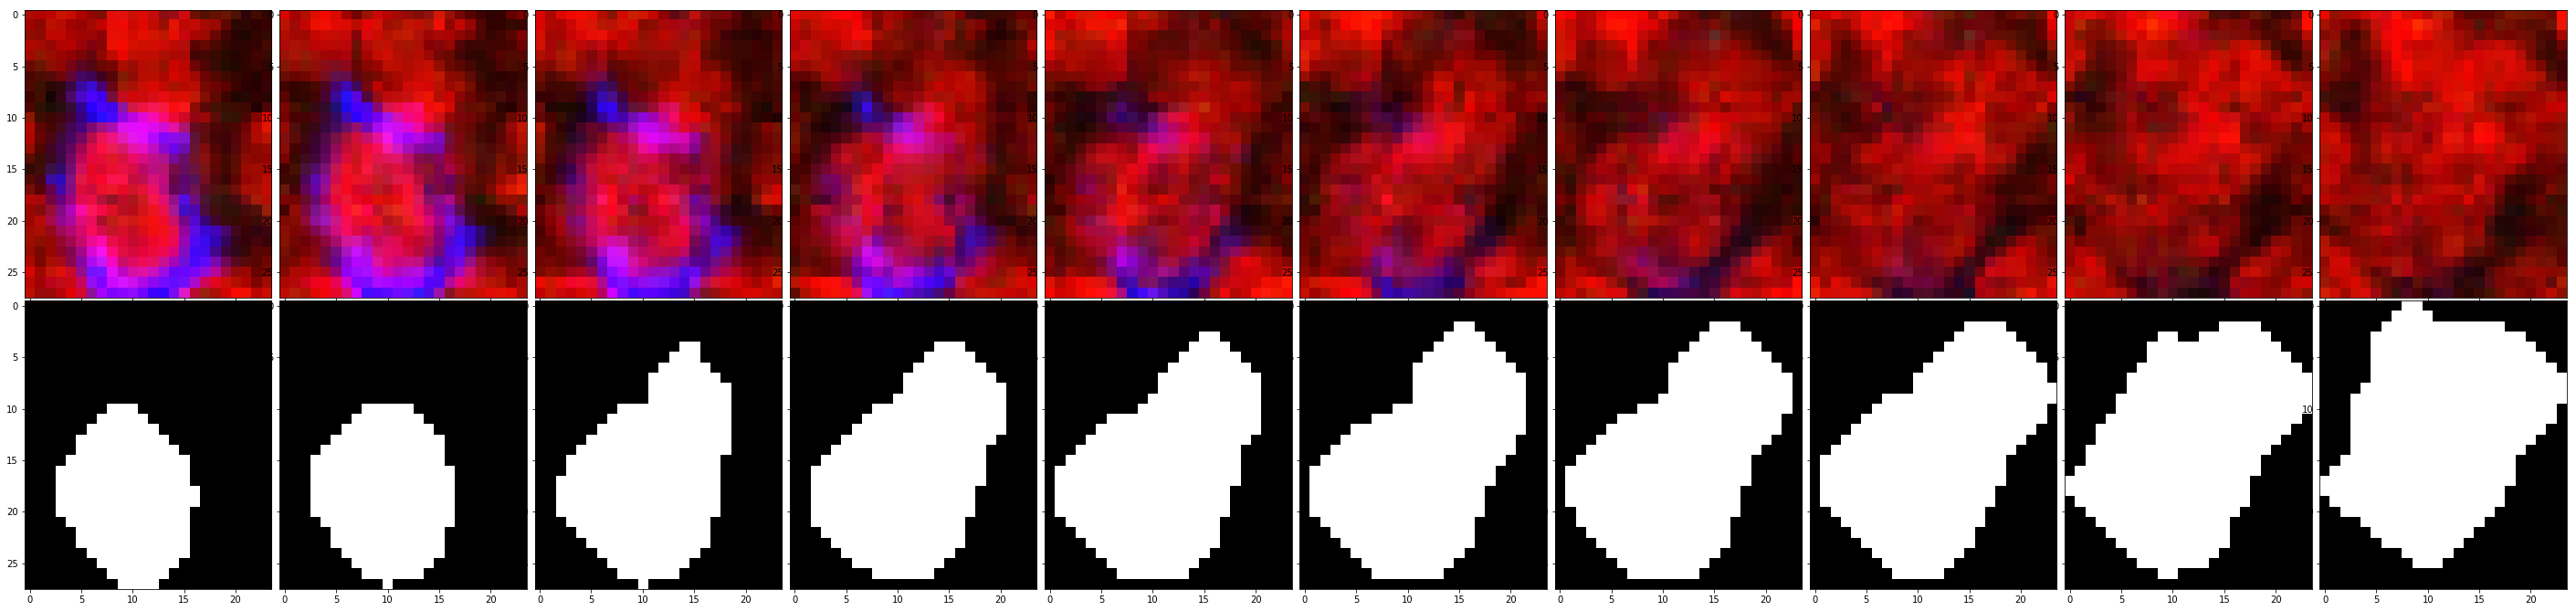

In [11]:
corner_case_image = resample(cell_image, pixel_size=(1, 0.57, 0.57), new_pixel_size=(3, 0.5,0.5))[0]
corner_case_labels = resample(cell_label, pixel_size=(1, 0.57, 0.57), new_pixel_size=(3, 0.5,0.5))[0]
print("Shape org: ",cell_image.shape, cell_label.shape, "Type: ", cell_image.dtype )
print("Shape: ",normalized_cell_image.shape, normalized_cell_label.shape,  "Type: ", cell_image.dtype)

show_all(2,len(corner_case_image), *(list(corner_case_image[:]) + list(corner_case_labels[:])), scale=5)

Shape org:  (10, 25, 21, 3) (10, 25, 21) Type:  float32
Shape:  (20, 28, 24, 3) (20, 28, 24) Type:  float32


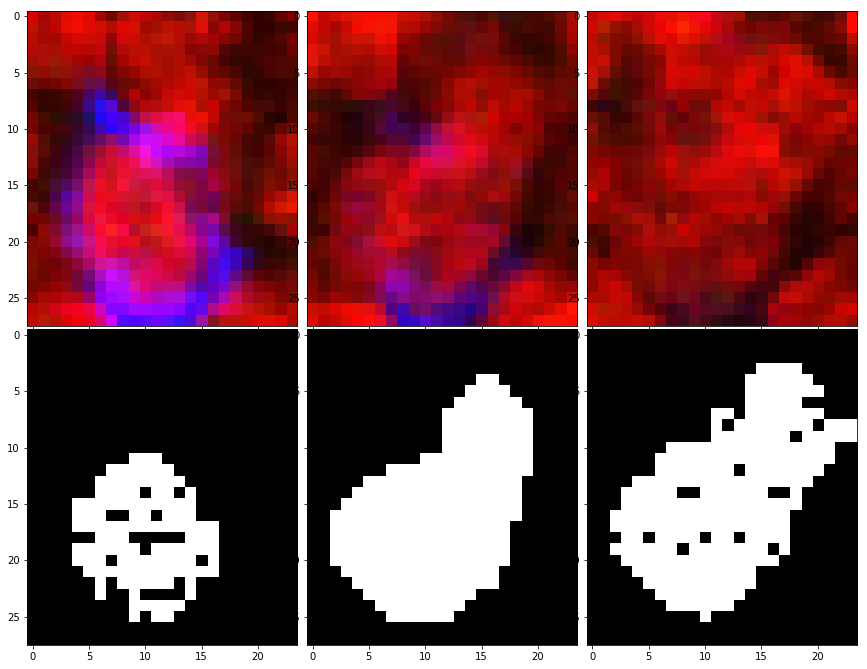

In [12]:
corner_case_image = resample2(cell_image, pixel_size=(1, 0.57, 0.57), new_pixel_size=(3, 0.5,0.5))[0]
corner_case_labels = resample2(cell_label, pixel_size=(1, 0.57, 0.57), new_pixel_size=(3, 0.5,0.5))[0]
print("Shape org: ",cell_image.shape, cell_label.shape, "Type: ", cell_image.dtype )
print("Shape: ",normalized_cell_image.shape, normalized_cell_label.shape,  "Type: ", cell_image.dtype)

show_all(2,len(corner_case_image), *(list(corner_case_image[:]) + list(corner_case_labels[:])), scale=5)

**The decision is to use resample v.1 as it do not have problems with missing points and we will usually upscale.**

### Show rescaled 3d

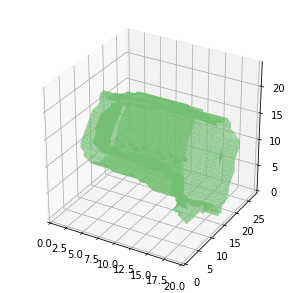

In [13]:
#%matplotlib notebook
plot_3d(normalized_cell_label)

## Shape features

In [14]:
import clb.classify.feature_extractor as clb_ext
importlib.reload(clb.classify.feature_extractor)

org = clb_ext.extract_shape_features(cell_label)
normalized = clb_ext.extract_shape_features(normalized_cell_label)

print ("Orginal:", cell_label.shape, org)
print ()
print ("Normalized:", normalized_cell_label.shape, normalized)


Orginal: (10, 25, 21) {1: {'second_major_axis': 0.7707580322844944, 'id': 1, 'pos_x': 9.84117125110914, 'length_1': 7.638794286433001, 'area': 2254, 'size_z': 10, 'length_0': 11.53661157519005, 'volume_um': 281.75, 'pos_y': 13.334960070984916, 'first_major_axis': 0.7493845767996091, 'pos_z': 5.136202307009761, 'length_2': 4.866889530009172, 'solidity': 0.8271559633027523}}

Normalized: (20, 28, 24) {1: {'second_major_axis': 0.8079645390047969, 'id': 1, 'pos_x': 11.354625550660794, 'length_1': 10.772240558586088, 'area': 4540, 'size_z': 20, 'length_0': 12.73105865852955, 'volume_um': 567.5, 'pos_y': 15.168942731277532, 'first_major_axis': 0.5329628648022607, 'pos_z': 10.902202643171806, 'length_2': 6.347339286376285, 'solidity': 0.7419512992319006}}


## Intensity complex features

In [15]:
org = clb_ext.extract_cells_features(cell_image[...,2], cell_label, 'complex')
normalized = clb_ext.extract_cells_features(normalized_cell_image[...,2], normalized_cell_label, 'complex')

#print ("Orginal:", cell_label.shape, org)
#print ()
print ("Normalized:", normalized_cell_label.shape, normalized)

Normalized: (20, 28, 24) {1: OrderedDict([('mean_intensity', 0.13220472444407014), ('std_intensity', 0.18705734264866788), ('perc_10_intensity', 0.006513261847196971), ('perc_20_intensity', 0.012689951382968242), ('perc_30_intensity', 0.021219581915582743), ('perc_40_intensity', 0.03129004793697408), ('perc_50_intensity', 0.05076866796636236), ('perc_60_intensity', 0.08074492573198641), ('perc_70_intensity', 0.13426263162603258), ('perc_80_intensity', 0.21926274526589917), ('perc_90_intensity', 0.3749405930188784), ('mad_intensity', 0.04256554263948996), ('mass_displace_in_diameters', 0.28870618250735564), ('mass_displace_in_majors', 0.2329417387626428), ('moment_normalized_0_0_2', 0.17173672229708692), ('moment_normalized_0_0_3', 0.0055768776695005505), ('moment_normalized_0_1_1', -0.045666314869328595), ('moment_normalized_0_1_2', -0.009675183776625391), ('moment_normalized_0_1_3', -0.016176854491258955), ('moment_normalized_0_2_0', 0.3201392607654901), ('moment_normalized_0_2_1', 0.

## Texture complex features

In [16]:
import mahotas

C:\Anacondas\2.5.0\envs\neptune3\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


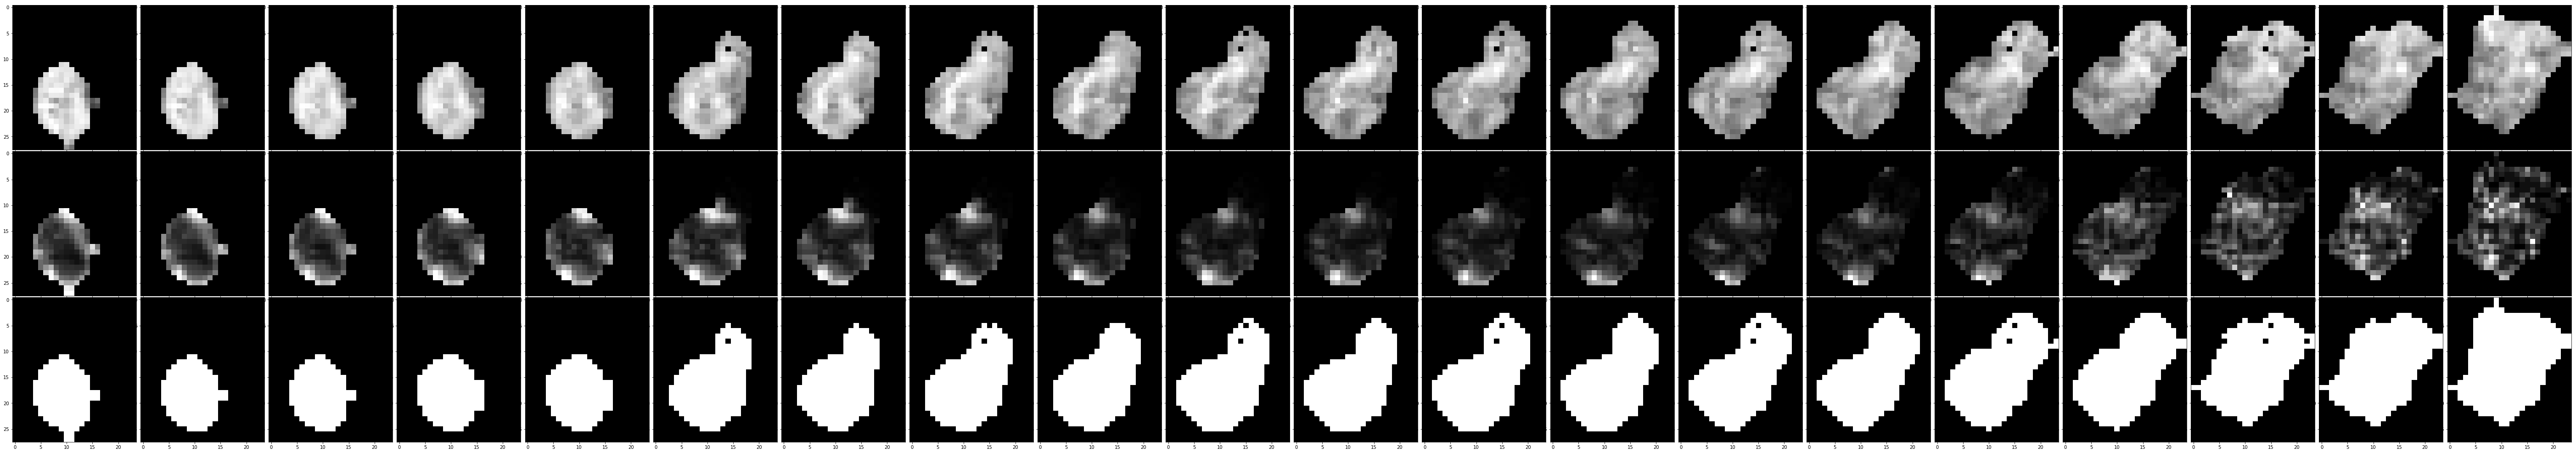

In [17]:
dapi_channels = skimage.img_as_ubyte(normalized_cell_image[...,0]) * ( normalized_cell_label> 0)
cd8_channels = skimage.img_as_ubyte(normalized_cell_image[...,2]) * ( normalized_cell_label> 0)
show_3d_slices(3, dapi_channels, cd8_channels,
               normalized_cell_label, scale=5)

In [18]:
HARALICK_NAMES = """AngularSecondMoment Contrast Correlation Variance
InverseDifferenceMoment SumAverage SumVariance SumEntropy Entropy
DifferenceVariance DifferenceEntropy InfoMeas1 InfoMeas2""".split()
len(HARALICK_NAMES)

13

In [22]:
features1 = mahotas.features.haralick(dapi_channels, distance=1, ignore_zeros=True)
features2 = mahotas.features.haralick(img_as_ubyte(dapi_channels), distance=2, ignore_zeros=True, return_mean_ptp=True)
features1.shape, features2.shape

((13, 13), (26,))

In [21]:
all_haralick = {}
for direction, haralick_features in enumerate(features1):
    for feature_idx, feature_value in enumerate(haralick_features):
        name = "haralick_{:02d}_{}".format(direction, HARALICK_NAMES[feature_idx])
        all_haralick[name] = feature_value

print(sorted(all_haralick.items()))

[('haralick_00_AngularSecondMoment', 0.0003305576344496706), ('haralick_00_Contrast', 134.71167707832785), ('haralick_00_Correlation', 0.9454786318157303), ('haralick_00_DifferenceEntropy', 4.601019871945143), ('haralick_00_DifferenceVariance', 0.00018036305848796762), ('haralick_00_Entropy', 11.837530006597824), ('haralick_00_InfoMeas1', -0.33716301645739055), ('haralick_00_InfoMeas2', 0.9958784566154858), ('haralick_00_InverseDifferenceMoment', 0.11892676115196293), ('haralick_00_SumAverage', 339.20326765977893), ('haralick_00_SumEntropy', 8.059789909123195), ('haralick_00_SumVariance', 4806.898614983162), ('haralick_00_Variance', 1235.4025730153553), ('haralick_01_AngularSecondMoment', 0.00023181894514470106), ('haralick_01_Contrast', 578.0624024961002), ('haralick_01_Correlation', 0.7640000935901053), ('haralick_01_DifferenceEntropy', 5.638881533995435), ('haralick_01_DifferenceVariance', 7.582206913542662e-05), ('haralick_01_Entropy', 12.262475782091812), ('haralick_01_InfoMeas1',

### Can it work in 2D? Will it be a subset of the features with directions on that plane?

In [ ]:
features_3d = mahotas.features.haralick(second_channels, distance=1, ignore_zeros=True)
#features_2don3d = mahotas.features.haralick(second_channels[:1], distance=1, ignore_zeros=True)
features_2d = mahotas.features.haralick(second_channels[0], distance=1, ignore_zeros=True)
features_2d, features_2d.shape

In [ ]:
second_channels_streatch_2d = np.stack([second_channels[0],second_channels[0]])
print("Stack shape:", second_channels_streatch_2d.shape)
features_3d_of_2d = mahotas.features.haralick(second_channels_streatch_2d, distance=1, ignore_zeros=True)
from_3d = np.stack([features_3d_of_2d[4], features_3d_of_2d[6], features_3d_of_2d[1], features_3d_of_2d[8]])
print("from_3d shape:", from_3d.shape)

In [ ]:
features_3d_of_2d;

In [ ]:
features_2d == from_3d